In [ ]:
import numpy as np
from imageio import imread, imwrite

# Hàm tính xác suất của phân phối Gaussian đa biến
def gaussian_pdf(x, mean, cov):
    """
    x: mảng (n_samples, D)
    mean: vector trung bình (D,)
    cov: ma trận hiệp phương sai (D, D)
    Trả về: mảng (n_samples,) chứa giá trị p(x|mean,cov)
    """
    D = x.shape[1]
    cov_inv = np.linalg.inv(cov)                          # Σ^{-1}
    det_cov = np.linalg.det(cov)                          # |Σ|
    norm_const = np.sqrt((2 * np.pi) ** D * det_cov)      # (2π)^{D/2} |Σ|^{1/2}
    diff = x - mean                                       # x - μ
    exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)  # -(1/2)(x-μ)^T Σ^{-1} (x-μ)
    return np.exp(exponent) / norm_const                  # công thức Gaussian

class GaussianMixtureEM:
    def __init__(self, n_components=2, max_iter=100, tol=1e-6):
        """
        n_components: K (số thành phần)
        max_iter: số lần lặp tối đa của EM
        tol: ngưỡng dừng khi log-likelihood thay đổi rất nhỏ
        """
        self.K = n_components
        self.max_iter = max_iter
        self.tol = tol

    def _init_params(self, X):
        N, D = X.shape
        # π_k khởi tạo đều nhau, thỏa Σ π_k = 1
        self.pi = np.full(self.K, 1 / self.K)               # π = [1/K, 1/K, ..., 1/K]
        # μ_k khởi tạo bằng K điểm ngẫu nhiên
        idx = np.random.choice(N, self.K, replace=False)
        self.mu = X[idx].copy()                             # μ_k
        # Σ_k khởi tạo giống nhau = hiệp phương sai chung của X
        cov0 = np.cov(X, rowvar=False) + np.eye(D)*1e-6     # thêm εI để tránh suy biến
        self.Sigma = np.array([cov0.copy() for _ in range(self.K)])

    def _e_step(self, X):
        """
        Bước E: tính γ_{nk} = p(k|x_n) = π_k · N(x_n|μ_k,Σ_k) / Σ_j [π_j · N(x_n|μ_j,Σ_j)]
        Trả về ma trận gamma shape (N, K)
        """
        N, _ = X.shape
        # Tính π_k · N(x_n|μ_k,Σ_k) cho tất cả n,k
        weighted_pdfs = np.zeros((N, self.K))
        for k in range(self.K):
            weighted_pdfs[:, k] = self.pi[k] * gaussian_pdf(X, self.mu[k], self.Sigma[k])
        # Tính mẫu số Σ_j π_j N(...)
        denom = np.sum(weighted_pdfs, axis=1, keepdims=True)  # shape (N,1)
        # γ_{nk}
        gamma = weighted_pdfs / denom                          # mỗi hàng sum=1
        return gamma

    def _m_step(self, X, gamma):
        """
        Bước M: cập nhật π_k, μ_k, Σ_k
          N_k = Σ_n γ_{nk}
          μ_k = (1/N_k) Σ_n γ_{nk} x_n
          Σ_k = (1/N_k) Σ_n γ_{nk} (x_n - μ_k)(x_n - μ_k)^T
          π_k = N_k / N
        """
        N, D = X.shape
        N_k = np.sum(gamma, axis=0)                        # N_k = Σ_n γ_{nk}

        # Cập nhật μ_k
        self.mu = (gamma.T @ X) / N_k[:, np.newaxis]       # shape (K,D)

        # Cập nhật Σ_k
        new_Sigma = []
        for k in range(self.K):
            diff = X - self.mu[k]                          # (N,D)
            # Σ_k = (1/N_k) Σ_n γ_{nk} diff_n diff_n^T
            S_k = (gamma[:, k][:, np.newaxis] * diff).T @ diff / N_k[k]
            S_k += np.eye(D) * 1e-6                        # ổn định
            new_Sigma.append(S_k)
        self.Sigma = np.array(new_Sigma)                  # shape (K,D,D)

        # Cập nhật π_k
        self.pi = N_k / N                                  # thỏa Σ π_k = 1

    def _compute_log_likelihood(self, X):
        """
        Tính log-likelihood: L = Σ_n ln [ Σ_k π_k N(x_n|μ_k,Σ_k) ]
        """
        N, _ = X.shape
        total = np.zeros(N)
        for k in range(self.K):
            total += self.pi[k] * gaussian_pdf(X, self.mu[k], self.Sigma[k])
        return np.sum(np.log(total))

    def fit(self, X):
        """
        Huấn luyện GMM với EM
        """
        # 1) Khởi tạo tham số
        self._init_params(X)
        prev_ll = None

        # 2) Lặp EM
        for i in range(self.max_iter):
            # E-step
            gamma = self._e_step(X)

            # M-step
            self._m_step(X, gamma)

            # Tính log-likelihood và kiểm tra hội tụ
            ll = self._compute_log_likelihood(X)
            if prev_ll is not None and abs(ll - prev_ll) < self.tol:
                print(f"EM hội tụ sau {i+1} vòng, ΔLL={abs(ll-prev_ll):.2e}")
                break
            prev_ll = ll

    def predict(self, X):
        """
        Phân cụm: trả về k có γ_{nk} lớn nhất
        """
        gamma = self._e_step(X)
        return np.argmax(gamma, axis=1)

# Hàm tính xác suất của phân phối Gaussian đa biến
def gaussian_pdf(x, mean, cov):
    """
    x: mảng (n_samples, D)
    mean: vector trung bình (D,)
    cov: ma trận hiệp phương sai (D, D)
    Trả về: mảng (n_samples,) chứa giá trị p(x|mean,cov)
    """
    D = x.shape[1]
    cov_inv = np.linalg.inv(cov)                          # Σ^{-1}
    det_cov = np.linalg.det(cov)                          # |Σ|
    norm_const = np.sqrt((2 * np.pi) ** D * det_cov)      # (2π)^{D/2} |Σ|^{1/2}
    diff = x - mean                                       # x - μ
    exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)  # -(1/2)(x-μ)^T Σ^{-1} (x-μ)
    return np.exp(exponent) / norm_const                  # công thức Gaussian

class GaussianMixtureEM:
    def __init__(self, n_components=2, max_iter=100, tol=1e-6):
        """
        n_components: K (số thành phần)
        max_iter: số lần lặp tối đa của EM
        tol: ngưỡng dừng khi log-likelihood thay đổi rất nhỏ
        """
        self.K = n_components
        self.max_iter = max_iter
        self.tol = tol

    def _init_params(self, X):
        N, D = X.shape
        # π_k khởi tạo đều nhau, thỏa Σ π_k = 1
        self.pi = np.full(self.K, 1 / self.K)               # π = [1/K, 1/K, ..., 1/K]
        # μ_k khởi tạo bằng K điểm ngẫu nhiên
        idx = np.random.choice(N, self.K, replace=False)
        self.mu = X[idx].copy()                             # μ_k
        # Σ_k khởi tạo giống nhau = hiệp phương sai chung của X
        cov0 = np.cov(X, rowvar=False) + np.eye(D)*1e-6     # thêm εI để tránh suy biến
        self.Sigma = np.array([cov0.copy() for _ in range(self.K)])

    def _e_step(self, X):
        """
        Bước E: tính γ_{nk} = p(k|x_n) = π_k · N(x_n|μ_k,Σ_k) / Σ_j [π_j · N(x_n|μ_j,Σ_j)]
        Trả về ma trận gamma shape (N, K)
        """
        N, _ = X.shape
        # Tính π_k · N(x_n|μ_k,Σ_k) cho tất cả n,k
        weighted_pdfs = np.zeros((N, self.K))
        for k in range(self.K):
            weighted_pdfs[:, k] = self.pi[k] * gaussian_pdf(X, self.mu[k], self.Sigma[k])
        # Tính mẫu số Σ_j π_j N(...)
        denom = np.sum(weighted_pdfs, axis=1, keepdims=True)  # shape (N,1)
        # γ_{nk}
        gamma = weighted_pdfs / denom                          # mỗi hàng sum=1
        return gamma

    def _m_step(self, X, gamma):
        """
        Bước M: cập nhật π_k, μ_k, Σ_k
          N_k = Σ_n γ_{nk}
          μ_k = (1/N_k) Σ_n γ_{nk} x_n
          Σ_k = (1/N_k) Σ_n γ_{nk} (x_n - μ_k)(x_n - μ_k)^T
          π_k = N_k / N
        """
        N, D = X.shape
        N_k = np.sum(gamma, axis=0)                        # N_k = Σ_n γ_{nk}

        # Cập nhật μ_k
        self.mu = (gamma.T @ X) / N_k[:, np.newaxis]       # shape (K,D)

        # Cập nhật Σ_k
        new_Sigma = []
        for k in range(self.K):
            diff = X - self.mu[k]                          # (N,D)
            # Σ_k = (1/N_k) Σ_n γ_{nk} diff_n diff_n^T
            S_k = (gamma[:, k][:, np.newaxis] * diff).T @ diff / N_k[k]
            S_k += np.eye(D) * 1e-6                        # ổn định
            new_Sigma.append(S_k)
        self.Sigma = np.array(new_Sigma)                  # shape (K,D,D)

        # Cập nhật π_k
        self.pi = N_k / N                                  # thỏa Σ π_k = 1

    def _compute_log_likelihood(self, X):
        """
        Tính log-likelihood: L = Σ_n ln [ Σ_k π_k N(x_n|μ_k,Σ_k) ]
        """
        N, _ = X.shape
        total = np.zeros(N)
        for k in range(self.K):
            total += self.pi[k] * gaussian_pdf(X, self.mu[k], self.Sigma[k])
        return np.sum(np.log(total))

    def fit(self, X):
        """
        Huấn luyện GMM với EM
        """
        # 1) Khởi tạo tham số
        self._init_params(X)
        prev_ll = None

        # 2) Lặp EM
        for i in range(self.max_iter):
            # E-step
            gamma = self._e_step(X)

            # M-step
            self._m_step(X, gamma)

            # Tính log-likelihood và kiểm tra hội tụ
            ll = self._compute_log_likelihood(X)
            if prev_ll is not None and abs(ll - prev_ll) < self.tol:
                print(f"EM hội tụ sau {i+1} vòng, ΔLL={abs(ll-prev_ll):.2e}")
                break
            prev_ll = ll

    def predict(self, X):
        """
        Phân cụm: trả về k có γ_{nk} lớn nhất
        """
        gamma = self._e_step(X)
        return np.argmax(gamma, axis=1)





C:\Users\DELL\AppData\Local\Temp\ipykernel_248\1556419424.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread(input_path).astype(np.float64)   # (H,W,3)


EM hội tụ sau 33 vòng, ΔLL=2.87e-06


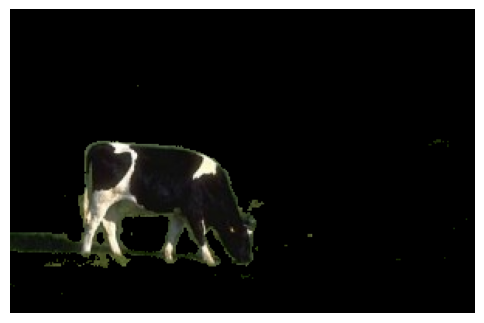

In [3]:
import matplotlib.pyplot as plt
input_path = (r'cow.jpg')    
# 1. Đọc ảnh và reshape
img = imread(input_path).astype(np.float64)   # (H,W,3)
H, W, C = img.shape
X = img.reshape(-1, C)                        # (N,3)

    # 2. Fit GMM
gmm = GaussianMixtureEM(n_components=2,max_iter=100,tol=1e-5)
gmm.fit(X)

    # 3. Dự đoán labels
labels = gmm.predict(X)                       # (N,)

    # 4. Xác định nhãn nền: thành phần có mean sáng hơn
brightness = gmm.mu.mean(axis=1)              # array([mean_k1, mean_k2])
bg_label = np.argmax(brightness)

    # 5. Tạo mask và áp lên ảnh
mask = (labels != bg_label).reshape(H, W)     # True=foreground
result = img.copy()
result[~mask] = 0                             # nền = đen

    # 6. Trả về mảng uint8 để hiển thị


# --- Cách dùng trong Notebook ---

# Bước 1: Gọi hàm để lấy ảnh đã tách nền
segmented = result.astype(np.uint8)

# Bước 2: Hiển thị với matplotlib
plt.figure(figsize=(6,6))
plt.imshow(segmented)
plt.axis('off')
plt.show()
